In [13]:
import pandas as pd
import numpy as np
import sys
import os
import warnings
import scipy.stats as stats
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
#FINANZAS
def vd_ctr(pago,n,i):

  #Pago -> Valor de la mensualidad
  #n -> Número de periodos
  # i -> Interés en a periocidad n
  #El n e i deben estar en la misma periodicidad

  pagos= np.ones(n)*pago
  print(pagos.sum())
  cap_factor=np.ones(n)*(1+i)**np.arange(n,0,-1)
  resp_vector= pagos*cap_factor
  resp= resp_vector.sum()

  return resp

In [3]:
#TABLAS MORTALIDAD
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def TMensual(Tmort):
   """
   Interpola los valores de l(x) en pasos de 1/12 (mensual) y calcula q(x) y p(x).
   Parameters:
   Tmort (DataFrame): DataFrame que contiene las columnas 'x' y 'l(x)'.
   Returns:
   DataFrame: DataFrame con valores interpolados de x, l(x), q(x) y p(x).
   """
   # Aseguramos que Tmort tiene las columnas adecuadas
   if 'x' not in Tmort.columns or 'l(x)' not in Tmort.columns:
       raise ValueError("El DataFrame debe contener las columnas 'x' y 'l(x)'")
   # Obtener los valores de x y l(x)
   x_values = Tmort['x'].values
   lx_values = Tmort['l(x)'].values
   # Crear una función de interpolación
   interp_function = interp1d(x_values, lx_values, kind='linear', fill_value='extrapolate')
   # Crear los nuevos valores de x con un paso de 1/12, hasta 110 (incluyendo 110)
   new_x = np.arange(x_values[0], 110 + 1/12, 1/12)  # Incrementos mensuales hasta 110
   # Calcular los valores de l(x) interpolados
   new_lx = interp_function(new_x)
   # Inicializar los arrays para q(x) y p(x)
   qx_values = np.zeros(len(new_x) - 1)  # Inicializar el array para q(x)
   px_values = np.zeros(len(new_x) - 1)  # Inicializar el array para p(x)
   # Calcular q(x) y p(x) para cada nuevo valor de x
   for i in range(len(new_x)-1):
       if new_lx[i] > 0:  # Evitar división por cero
           qx_values[i] = 1 - (new_lx[i + 1] / new_lx[i])  # q(x) = 1 - l(x + 1/12) / l(x)
       else:
           qx_values[i] = 0  # Si l(x) es 0, q(x) también debe ser 0
       px_values[i] = 1 - qx_values[i]  # p(x) = 1 - q(x)

   # Crear un nuevo DataFrame con los valores interpolados y calculados
   interpolated_df = pd.DataFrame({
       'x': new_x,  # Incluir hasta 110
       'l(x)': new_lx,  # Excluir el último por la misma razón
       'q(x)': np.append(qx_values, 1),  # Añadir el valor de q(110)
       'p(x)': np.append(px_values, 0)  # Añadir el valor de p(110)
   })
   return interpolated_df
def tmort_filtered(df,edad):
   qx_vec=df[df['x']>=edad]
   return qx_vec


In [31]:
pd.set_option('display.float_format','{:,.2f}'.format)


In [32]:
ruta = r'/content/datos_longevidad.xlsx'
data= pd.read_excel(ruta,'Data')
print(data.columns)
data=data[['Edad','Casado','Genero','Edad_pareja','Sexo_pareja','Pago_mensual']]
data.head()

Index(['Unnamed: 0', 'Edad', 'Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja',
       'Pago_mensual'],
      dtype='object')


,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual
0,68,0,M,0,0,"4,196,583.06"
1,67,1,H,67,H,"1,983,941.40"
2,80,1,H,77,H,"4,014,628.81"
3,71,1,H,85,M,"5,710,179.97"
4,66,0,M,0,0,"7,882,172.76"


In [33]:
ruta_m = r'/content/TM_mujeres.xlsx'
ruta_h = r'/content/TM_hombres.xlsx'
tmor_m= pd.read_excel(ruta_m)
tmor_h= pd.read_excel(ruta_h)
T_hombre=TMensual(tmor_h)
T_mujer=TMensual(tmor_m)

In [40]:
valoracion_jubilado = []
valoracion_pareja = []
i = 0.04 / 12

for index, row in data.iterrows():
    genero = row['Genero']
    if genero == 'H':
        tmort = T_hombre
    else:
        tmort = T_mujer

    if row['Casado'] == 0:
        # Renta Vitalicia
        edad = row['Edad']
        # Convert 'pago' to a numeric type before calculation
        pago = float(row['Pago_mensual'].replace(',', ''))
        T = tmort_filtered(tmort, edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()
        va_pareja = 0
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

    elif row['Casado'] == 1:
        # Renta Vitalicia Reversible
        edad = row['Edad']
        # Convert 'pago' to a numeric type before calculation
        pago = float(row['Pago_mensual'].replace(',', ''))
        T = tmort_filtered(tmort, edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()

        edad_pareja = row['Edad_pareja']
        genero_pareja = row['Sexo_pareja']
        if genero_pareja == 'H':
            tmort_pareja = T_hombre
        else:
            tmort_pareja = T_mujer

        T_par = tmort_filtered(tmort_pareja, edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja) * 12
        T_par['Vn'] = np.ones(len(T_par)) * (1 / (1 + i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)

        if edad <= edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista = []
            gap = (edad - edad_pareja) * 12
            lista = list(T['q(x)']) + list(np.ones(gap))
            T_par['q(x)_Jub'] = lista

        sum_vect_pareja = pago * T_par['Vn'] * T_par['p(x)'] * T_par['q(x)_Jub']
        va_pareja = sum_vect_pareja.sum()

        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

data['Valoracion Jubilado'] = valoracion_jubilado
data['valoracion pareja'] = valoracion_pareja
data['Valoracion'] = data['Valoracion Jubilado'] + data['valoracion pareja']
# Formatting moved to the end
data['Pago_mensual'] = data['Pago_mensual'].apply(lambda x: f'{float(x.replace(",", "")):,.2f}')

In [41]:
data.head()

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion,valoracion pareja
0,68,0,M,0,0,"4,196,583.06","1,017,456,035.98",0.00,"1,017,456,035.98",0.00
1,67,1,H,67,H,"1,983,941.40","484,784,234.57","2,596.55","489,770,075.31","4,985,840.73"
2,80,1,H,77,H,"4,014,628.81","828,188,996.21","17,969.09","881,797,558.43","53,608,562.22"
3,71,1,H,85,M,"5,710,179.97","1,339,739,653.98","39,672.81","1,346,681,022.11","6,941,368.13"
4,66,0,M,0,0,"7,882,172.76","1,946,327,114.30",0.00,"1,946,327,114.30",0.00


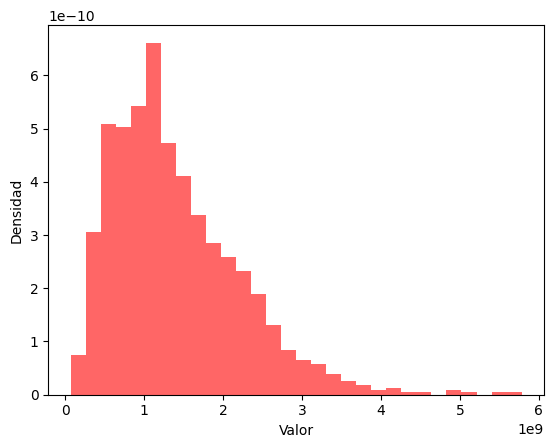

In [47]:
#HISTOGRAMA
plt.hist(data['Valoracion'], bins=30, density=True, alpha=0.6, color='r', label='Datos')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.show()

In [43]:
#Ajustar la distribución gamma a los datos
shape, loc, scale = stats.gamma.fit(data['Valoracion'])


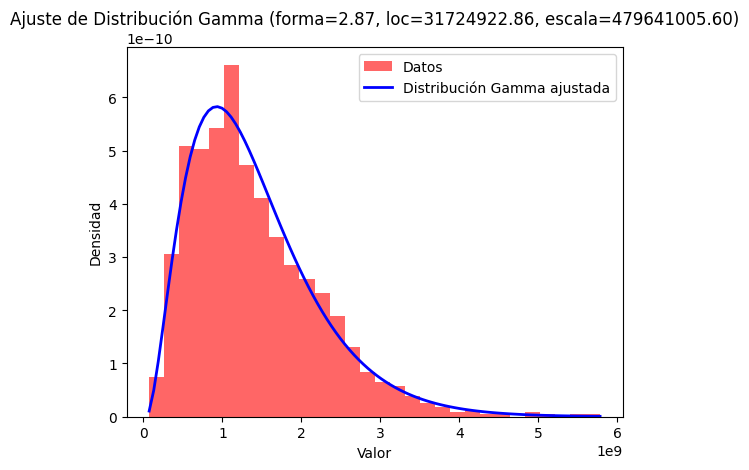

In [49]:
#Crear rango de valores para la gráfica
x = np.linspace(data['Valoracion'].min(), data['Valoracion'].max(), 100)

#Función de densidad ajustada usando los parámetros obtenidos
pdf_gamma = stats.gamma.pdf(x, shape, loc, scale)

#Graficar el histograma
plt.hist(data['Valoracion'], bins=30, density=True, alpha=0.6, color='r', label='Datos')

#Graficar la función gamma ajustada
plt.plot(x, pdf_gamma, 'b-', linewidth=2, label='Distribución Gamma ajustada')

#Mostrar gráfica
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title(f"Ajuste de Distribución Gamma (forma={shape:.2f}, loc={loc:.2f}, escala={scale:.2f})")
plt.legend()
plt.show()

In [50]:
#Definir el intervalo de confianza de la distribucion al 5%

shape = 2.87 #Nuevo arametro de forma
scale = 479640997 # Nuevo parametro de escala

quantile_5 = stats.gamma.ppf(0.05,a=shape, scale=scale)
quantile_95 = stats.gamma.ppf(0.95,a=shape, scale=scale)

print(f"Cuantil al 5%: ({quantile_5}")
print(f"Cuantil al 95%: ({quantile_95}")


Cuantil al 5%: (360576647.60582757
Cuantil al 95%: (2926050013.444586


In [52]:
#Calcule el valor del objetivo corporativo, si este es reducir el compromiso total por pensiones en al menos un 30%
total= data['Valoracion'].sum()
objetivo=total*0.3
print('El objetivo del banco es reducir el compromiso total por pensiones en al menos:', objetivo)

El objetivo del banco es reducir el compromiso total por pensiones en al menos: 506252650354.96344


In [53]:
total

np.float64(1687508834516.545)

In [54]:
#La probabilidad de aceptación de esta propuesta se comporta como una distribución binomial de parámetro P
#Como consultor debe decidir el % mínimo de aceptación del colectivo para que el proyecto sea viable (la P min de la binomial)
df_sim = pd.DataFrame()
df_sim['key'] = list(data.index)
df_sim['Valoración'] = list(data.Valoracion)

#Le daremos a cada persona el 70% del valor de la renta
d = 0.7
df_sim['Pago_hoy'] = (d) * df_sim['Valoración']

sim = 500
p = 0.3  # Valor de aceptación minimo

for i in range(500): #Genera 500 simulaciones
#Genera las muestras de la distribución binomial
    samples = np.random.binomial(1, p, len(df_sim))
    #Crea la nueva columna para la simulación
    df_sim['Aceptación_' + str(i)] = samples
    #Aplica la lógica a cada fila
    #Si el valor de la simulación es 2, toma Pago_hoy: si es 0 toma Valoracion
    df_sim['sim_' + str(i)] = df_sim.apply(
        lambda row: row['Pago_hoy'] if row['Aceptación_' + str(i)] == 1 else row['Valoración'],
        axis=1
    )

In [55]:
df_sim

,key,Valoración,Pago_hoy,Aceptación_0,sim_0,Aceptación_1,sim_1,Aceptación_2,sim_2,Aceptación_3,...,Aceptación_495,sim_495,Aceptación_496,sim_496,Aceptación_497,sim_497,Aceptación_498,sim_498,Aceptación_499,sim_499
0,0,"1,017,456,035.98","712,219,225.19",1,"712,219,225.19",0,"1,017,456,035.98",0,"1,017,456,035.98",1,...,0,"1,017,456,035.98",0,"1,017,456,035.98",1,"712,219,225.19",0,"1,017,456,035.98",0,"1,017,456,035.98"
1,1,"489,770,075.31","342,839,052.72",1,"342,839,052.72",1,"342,839,052.72",0,"489,770,075.31",0,...,0,"489,770,075.31",0,"489,770,075.31",0,"489,770,075.31",1,"342,839,052.72",1,"342,839,052.72"
2,2,"881,797,558.43","617,258,290.90",0,"881,797,558.43",0,"881,797,558.43",0,"881,797,558.43",0,...,1,"617,258,290.90",0,"881,797,558.43",1,"617,258,290.90",1,"617,258,290.90",0,"881,797,558.43"
3,3,"1,346,681,022.11","942,676,715.48",1,"942,676,715.48",1,"942,676,715.48",0,"1,346,681,022.11",0,...,1,"942,676,715.48",0,"1,346,681,022.11",0,"1,346,681,022.11",1,"942,676,715.48",0,"1,346,681,022.11"
4,4,"1,946,327,114.30","1,362,428,980.01",0,"1,946,327,114.30",0,"1,946,327,114.30",0,"1,946,327,114.30",0,...,1,"1,362,428,980.01",0,"1,946,327,114.30",0,"1,946,327,114.30",0,"1,946,327,114.30",0,"1,946,327,114.30"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,"640,482,469.55","448,337,728.69",1,"448,337,728.69",1,"448,337,728.69",0,"640,482,469.55",0,...,0,"640,482,469.55",0,"640,482,469.55",0,"640,482,469.55",0,"640,482,469.55",0,"640,482,469.55"
1196,1196,"913,985,754.29","639,790,028.00",0,"913,985,754.29",0,"913,985,754.29",1,"639,790,028.00",0,...,0,"913,985,754.29",0,"913,985,754.29",1,"639,790,028.00",0,"913,985,754.29",0,"913,985,754.29"
1197,1197,"846,745,508.93","592,721,856.25",0,"846,745,508.93",0,"846,745,508.93",0,"846,745,508.93",0,...,1,"592,721,856.25",1,"592,721,856.25",0,"846,745,508.93",0,"846,745,508.93",1,"592,721,856.25"
1198,1198,"2,348,062,669.82","1,643,643,868.87",1,"1,643,643,868.87",1,"1,643,643,868.87",0,"2,348,062,669.82",0,...,0,"2,348,062,669.82",0,"2,348,062,669.82",1,"1,643,643,868.87",0,"2,348,062,669.82",1,"1,643,643,868.87"
